In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import pandas as pd

#  Upload file
df = pd.read_csv('/content/drive/MyDrive/content/Superstore.csv', dtype=str, encoding='cp1252') #Here i found that it should be here, since my encoding is not UTF-8


# Deleting (cleaning) columns (spaces and other trash) cycle
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].map(lambda x: x.replace('\xa0',' ').strip() if isinstance(x, str) else x)

#  Changing dates in Order Date (so many wrong rows)
def fix_order_date(date_str):
    import pandas as pd
    if pd.isna(date_str) or str(date_str).strip() == '':
        return pd.NaT
    try:
        date_str = str(date_str).replace('"','').strip()
        if '.' in date_str:
            parts = date_str.split('.')
        elif '/' in date_str:
            parts = date_str.split('/')
        else:
            return pd.NaT
        if len(parts) != 3:
            return pd.NaT
        first, second, year = int(parts[0]), int(parts[1]), int(parts[2])

        # I found out that many places it was misplaced date/month
        if second > 12:
            return pd.Timestamp(year=year, month=first, day=second)
        else:
            return pd.Timestamp(year=year, month=second, day=first)
    except:
        return pd.NaT

df['Order Date'] = df['Order Date'].apply(fix_order_date)

#  Adding columns Order Year & Order Month
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.strftime('%Y-%m')

#  Sales & Profit wasn't numbers(deleting $ and commas if ixists)
for col in ['Sales', 'Profit']:
    df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)

# calculating Profit Margin
df['Profit Margin'] = df.apply(lambda row: 0 if row['Sales']==0 else row['Profit']/row['Sales'], axis=1)

#  screen results
print(df[['Order Date','Order Year','Order Month','Sales','Profit','Profit Margin']].head(100))
print("Missing dates:", df['Order Date'].isna().sum())


   Order Date  Order Year Order Month     Sales    Profit  Profit Margin
0  2016-08-11        2016     2016-08  261.9600   41.9136       0.160000
1  2016-08-11        2016     2016-08  731.9400  219.5820       0.300000
2  2016-12-06        2016     2016-12   14.6200    6.8714       0.470000
3  2015-11-10        2015     2015-11  957.5775 -383.0310      -0.400000
4  2015-11-10        2015     2015-11   22.3680    2.5164       0.112500
..        ...         ...         ...       ...       ...            ...
95 2017-06-11        2017     2017-06    5.6820   -3.7880      -0.666667
96 2017-09-11        2017     2017-09   96.5300   40.5426       0.420000
97 2017-06-17        2017     2017-06   51.3120   17.9592       0.350000
98 2016-06-09        2016     2016-06   77.8800   22.5852       0.290000
99 2016-08-29        2016     2016-08   64.6240   22.6184       0.350000

[100 rows x 6 columns]
Missing dates: 0


In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])


In [ ]:
df['Margin'] = df['Profit'] / df['Sales']


Category
Furniture          741999.7953
Office Supplies    719047.0320
Technology         836154.0330
Name: Sales, dtype: float64
Product Name
Canon imageCLASS 2200 Advanced Copier                                    5039.985600
Canon imageCLASS MF7460 Monochrome Digital Laser Multifunction Copier    1995.990000
Ativa V4110MDD Micro-Cut Shredder                                        1886.473050
3D Systems Cube Printer, 2nd Generation, Magenta                         1858.985700
Zebra ZM400 Thermal Label Printer                                        1671.768000
                                                                            ...     
Zebra GK420t Direct Thermal/Thermal Transfer Printer                     -938.280000
Lexmark MX611dhe Monochrome Laser Printer                               -1147.493250
Cisco TelePresence System EX90 Videoconferencing Unit                   -1811.078400
Cubify CubeX 3D Printer Double Head Print                               -2959.990133
Cubify 

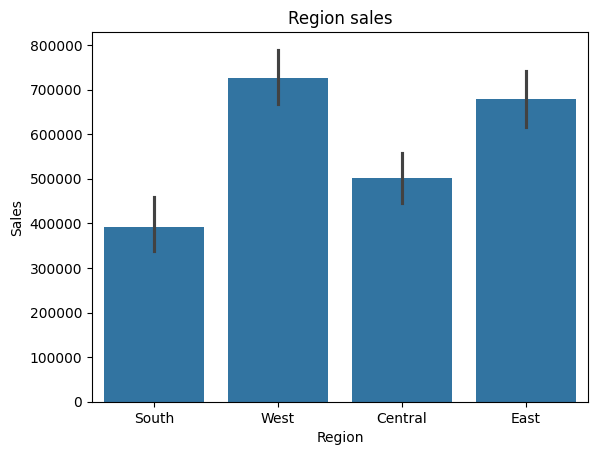

In [ ]:
# sum of sales by category
sales_by_category = df.groupby('Category')['Sales'].sum()
print(sales_by_category)

# avg profit by product
profit_by_product = df.groupby('Product Name')['Profit'].mean().sort_values(ascending=False)
print(profit_by_product)

# sales by region
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Region', y='Sales', data=df, estimator=sum)
plt.title("Region sales")
plt.show()


In [ ]:
#  top sales by sales and top by profit
top_profit_products = df.groupby('Product Name')['Profit'].sum().sort_values(ascending=False).head(10)
print(top_profit_products)



Product Name
Canon imageCLASS 2200 Advanced Copier                                          25199.9280
Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind     7753.0390
Hewlett Packard LaserJet 3310 Copier                                            6983.8836
Canon PC1060 Personal Laser Copier                                              4570.9347
HP Designjet T520 Inkjet Large Format Printer - 24" Color                       4094.9766
Ativa V4110MDD Micro-Cut Shredder                                               3772.9461
3D Systems Cube Printer, 2nd Generation, Magenta                                3717.9714
Plantronics Savi W720 Multi-Device Wireless Headset System                      3696.2820
Ibico EPK-21 Electric Binding System                                            3345.2823
Zebra ZM400 Thermal Label Printer                                               3343.5360
Name: Profit, dtype: float64


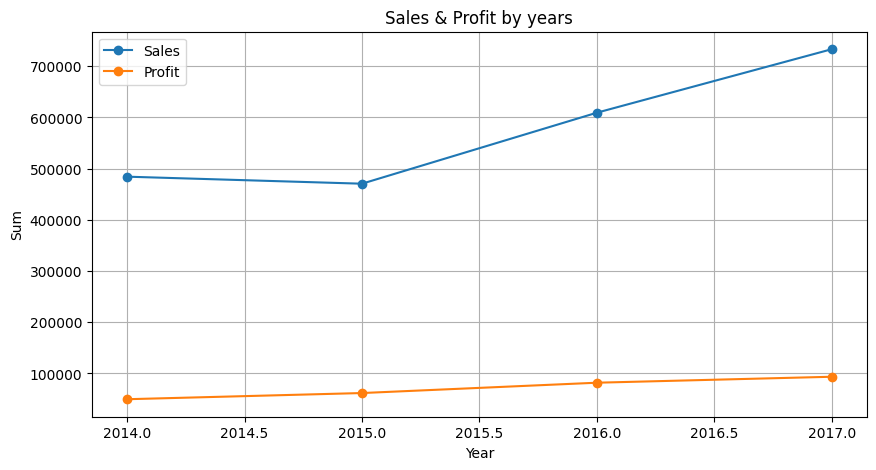

In [ ]:
#  Sales by year
sales_by_year = df.groupby('Order Year')['Sales'].sum()
profit_by_year = df.groupby('Order Year')['Profit'].sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(sales_by_year.index, sales_by_year.values, marker='o', label='Sales')
plt.plot(profit_by_year.index, profit_by_year.values, marker='o', label='Profit')
plt.title("Sales & Profit by years")
plt.xlabel("Year")
plt.ylabel("Sum")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import sqlite3

# Adding sql in Colab
conn = sqlite3.connect('superstore.db')
df.to_sql('superstore', conn, if_exists='replace', index=False)

# sales by category
query = "SELECT Category, SUM(Sales) as TotalSales FROM superstore GROUP BY Category"
sales_by_category_sql = pd.read_sql(query, conn)
print(sales_by_category_sql)



          Category   TotalSales
0        Furniture  741999.7953
1  Office Supplies  719047.0320
2       Technology  836154.0330


In [ ]:
# top 10 profit (products)
query = """
SELECT "Product Name", SUM(Profit) AS TotalProfit
FROM superstore
GROUP BY "Product Name"
ORDER BY TotalProfit DESC
LIMIT 10
"""
pd.read_sql(query, conn)


,Product Name,TotalProfit
0,Canon imageCLASS 2200 Advanced Copier,25199.9280
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,7753.0390
2,Hewlett Packard LaserJet 3310 Copier,6983.8836
3,Canon PC1060 Personal Laser Copier,4570.9347
4,HP Designjet T520 Inkjet Large Format Printer ...,4094.9766
5,Ativa V4110MDD Micro-Cut Shredder,3772.9461
6,"3D Systems Cube Printer, 2nd Generation, Magenta",3717.9714
7,Plantronics Savi W720 Multi-Device Wireless He...,3696.2820
8,Ibico EPK-21 Electric Binding System,3345.2823
9,Zebra ZM400 Thermal Label Printer,3343.5360


from matplotlib import pyplot as plt
_df_0['TotalProfit'].plot(kind='hist', bins=20, title='TotalProfit')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TotalProfit'].plot(kind='line', figsize=(8, 4), title='TotalProfit')
plt.gca().spines[['top', 'right']].set_visible(False)